# Sphères de Livermore


## Description rapide de l'expérience

Les expériences dites "Sphères de Livermore" ont été réalisées fin des années 60 - début des années 70 au Lawrence Livermore Laboratory (États-Unis).

Une sphère creuse est placée au centre d'un bunker. En son centre on a une source de neutrons à 14 MeV (faisceau de $^2\mathrm{H}^+$ sur une cible d'tritium, réaction $^3\mathrm{H}(d, n)^4\mathrm{He}$). Des détecteurs sont positionnés autour de la sphère après collimation.

On observe le spectre en temps des neutrons qui arrivent dans les détecteurs (réponse type `REACTION` dans Tripoli-4).

Pour une sphère donnée on exécute deux fois la simulation :
- avec la sphère étudiée (matériau = fer, béryllium, azote, eau, etc)
- avec la même sphère dont le matériau étudié a été remplacé par de l'**air**

Cette seconde sphère nous permet de normaliser les résultats et de pouvoir nous comparer aux données expérimentales notamment grâce à un graphique. Il y a donc deux sorties Tripoli-4 à lire et des opérations à faire sur les spectres.

Dans le cas présent la sphère considérée est celle d'azote liquide, d'une épaisseur de 3.1 mfp (libre parcours moyen), avec un spectre à 30°.

<img src="N_3.1mfp.png" width="600">


## Parsing des résultats Tripoli-4 et récupération du spectre

### Parser les résultats


In [1]:
from valjean.eponine.tripoli4.parse import Parser
jdd_sphere = 'prob103_nitrogen3.1_fine_timeShifted_sphere_PARA.d.res'
jdd_air = 'prob103_nitrogen3.1_fine_timeShifted_air_PARA.d.res'

Le module permettant de lire, parser et récupérer les résultats de Tripoli-4 sous un format plus facilement exploitable est `Parser`.

On ne regardera que le résultat du dernier batch. Le parsing est effectivement fait par la méthode `parse_from_index`.

Pour manipuler plus aisément les réponses de Tripoli-4 et en particulier les sélectionner on utilise un objet `Browser`.

In [2]:
sphere_b = Parser(jdd_sphere).parse_from_index(name='sphere').to_browser()
air_b = Parser(jdd_air).parse_from_index(name='air').to_browser()

* Parsing prob103_nitrogen3.1_fine_timeShifted_sphere_PARA.d.res
* Successful scan in 0.297490 s
* Successful parsing in 2.425650 s
* Parsing prob103_nitrogen3.1_fine_timeShifted_air_PARA.d.res
* Successful scan in 0.293505 s
* Successful parsing in 2.369055 s


### Sélection du résultat

À chaque réponse dans ce jeu de données a été associé un `SCORE NAME` unique (et explicite). C'est le moyen le plus aisé de récupérer les réponses nécessaires.

Dans le cas de la sphère (ici d'azote liquide), on récupère `score_name='neutron_response_30deg'`, soit le spectre neutron à 30 degrés (des spectres photons sont aussi disponibles). Il s'agira du numérateur (variable `nsphere`). Dans le cas de l'air, seule l'intégrale du spectre est nécessaire pour la normalisation, donc au dénominateur (variable `dair`). La sélection de la réponse se fait sur `score_name='neutron_response_integral_30deg'`.

In [3]:
nsphere = sphere_b.select_by(score_name='neutron_response_30deg', squeeze=True)
dair = air_b.select_by(score_name='neutron_response_integral_30deg', squeeze=True)

### Transformation des données en `Dataset`

Pour pouvoir manipuler les données plus aisément mais aussi pour faciliter leur manipulation, elles sont transformées en `Dataset`.

Le but de `Dataset` est d'être commun à tous les types de données (Tripoli-4, données expérimentales, PATMOS, MCNP, etc). Chaque dataset contient au moins 2 membres : `value` et `error`. Il s'agit de l'incertitude absolue (et non pas relative comme dans les résultats standard Tripoli-4). Trois autres membres sont optionnels : `bins`, `name` et `what`.

Un module, `data_convertor.py`, permet la conversion des données en `Dataset`, en fonction du type de données (spectre, score générique, etc).

In [4]:
import valjean.eponine.tripoli4.data_convertor as dcv
from valjean.eponine.dataset import Dataset

Pour info :

In [5]:
test_ds = dcv.convert_data(nsphere['results'], 'spectrum')
print(test_ds.shape)

(1, 1, 1, 1, 138, 1, 1)


In [6]:
print(test_ds.squeeze().shape)

(138,)


Les `Dataset` sont *squeezés* : nous récupérons des spectres en temps, les 6 autres dimensions sont donc à 1 et non utiles ici (et triviales).

Le numérateur, variable `numds`, sera le dataset transformé.

In [7]:
nsphereds = dcv.convert_data(nsphere['results'], 'spectrum', name="azote (num)").squeeze()

In [8]:
dairds = dcv.convert_data(dair['results'], 'spectrum', name='air (denom)').squeeze()
print(dairds)

shape: (3,), dim: 1, type: <class 'numpy.ndarray'>, bins: ['t: [0.00e+00 2.38e-07 5.10e-07 1.00e+01]'],name: air (denom), what: 


### Normalisation du spectre

Le résultat correspondant à l'intégrale du spectre n'est en réalité ici pas un score générique, mais un réel spectre. Cette différence est due aux intervalles extrêmes :
- entre t=0 et le début des résultats expérientaux, à t=138 ns pour le premier
- entre t=410 ns et t=10 s pour le dernier, soit entre la fin des résultats expérimentaux et la valeur maximale du temps dans Tripoli-4

Pour être plus juste, notamment au niveau du calcul des incertitudes associées, le choix a été fait de faire un spectre de 3 intervalles où seul celui du milieu nous intéresse dans le cas présent.

L'incertitude sur la norme est négligée par la suite (elle est dominée par celle sur chaque intervalle).

In [9]:
import numpy as np
norm = dairds.value[1]
print("type(norm) = {0}, shape(norm) = {1}".format(type(norm), norm.shape))

type(norm) = <class 'numpy.float64'>, shape(norm) = ()


En réalité deux normalisations du spectre sont à effectuer, celle par l'intégrale de l'air et celle par la largeur des bins, appelée ici `TIME_BIN_WIDTH`, valant 2&nbsp;ns.

In [10]:
TIME_BIN_WIDTH = 2
t4ds = nsphereds / norm / TIME_BIN_WIDTH

Remarque : il n'aurait pas été possible d'utiliser un `Dataset` issu de `dairds` pour la normalisation.

In [11]:
print(dairds)
test_dairds = dairds.copy()[1:-1]
print(test_dairds)

shape: (3,), dim: 1, type: <class 'numpy.ndarray'>, bins: ['t: [0.00e+00 2.38e-07 5.10e-07 1.00e+01]'],name: air (denom), what: 
shape: (1,), dim: 1, type: <class 'numpy.ndarray'>, bins: ['t: [2.38e-07 5.10e-07]'],name: air (denom), what: 


In [12]:
test_ds = nsphereds / test_dairds / TIME_BIN_WIDTH

ValueError: Datasets to divide do not have same shape

Ces deux datasets n'ont bien pas les shapes or les calculs sur les `Dataset` ne peuvent être effectués que s'ils ont la même *shape* et, dans le cas où des bins ont été fournis, si leurs bins sont équivalents.

In [13]:
'shape(t4ds) = {0}, shape(test_dairds) = {1}'.format(t4ds.shape, test_dairds.shape)

'shape(t4ds) = (138,), shape(test_dairds) = (1,)'

### Réarrangement des intervalles

Les temps sont par défaut en *s* dans Tripoli-4 alors que les données que nous avons à disposition sont données par intervalles de temps en *ns*, on convertit donc les intervalles de Tripoli-4 en *ns*.

Par ailleurs, les intervalles en temps dans le jeu de données ont été décalés de 100 ns pour que la description de la source (gaussienne) soit correcte et complètement prise en compte dans le temps de la simulation (jeu de données tourné avec Tripoli-4, version 10.2, ce bug a été corrigé pour la version 11, mais c'est une jolie illustration des calculs possibles sur les `Dataset`).

In [14]:
print('Bins en s et avant décalage:\n',t4ds.bins['t'] )
t4ds.bins['t'] = t4ds.bins['t'] * 1e9 - 100
print('Bins en ns et après décalage:\n', t4ds.bins['t'])

Bins en s et avant décalage:
 [0.00e+00 2.38e-07 2.40e-07 2.42e-07 2.44e-07 2.46e-07 2.48e-07 2.50e-07
 2.52e-07 2.54e-07 2.56e-07 2.58e-07 2.60e-07 2.62e-07 2.64e-07 2.66e-07
 2.68e-07 2.70e-07 2.72e-07 2.74e-07 2.76e-07 2.78e-07 2.80e-07 2.82e-07
 2.84e-07 2.86e-07 2.88e-07 2.90e-07 2.92e-07 2.94e-07 2.96e-07 2.98e-07
 3.00e-07 3.02e-07 3.04e-07 3.06e-07 3.08e-07 3.10e-07 3.12e-07 3.14e-07
 3.16e-07 3.18e-07 3.20e-07 3.22e-07 3.24e-07 3.26e-07 3.28e-07 3.30e-07
 3.32e-07 3.34e-07 3.36e-07 3.38e-07 3.40e-07 3.42e-07 3.44e-07 3.46e-07
 3.48e-07 3.50e-07 3.52e-07 3.54e-07 3.56e-07 3.58e-07 3.60e-07 3.62e-07
 3.64e-07 3.66e-07 3.68e-07 3.70e-07 3.72e-07 3.74e-07 3.76e-07 3.78e-07
 3.80e-07 3.82e-07 3.84e-07 3.86e-07 3.88e-07 3.90e-07 3.92e-07 3.94e-07
 3.96e-07 3.98e-07 4.00e-07 4.02e-07 4.04e-07 4.06e-07 4.08e-07 4.10e-07
 4.12e-07 4.14e-07 4.16e-07 4.18e-07 4.20e-07 4.22e-07 4.24e-07 4.26e-07
 4.28e-07 4.30e-07 4.32e-07 4.34e-07 4.36e-07 4.38e-07 4.40e-07 4.42e-07
 4.44e-07 4.46e-07 4.

De plus, le dataset actuel, `t4ds`, contient toujours les bins extrêmes, il faut donc les enlever.

Le *slicing* a été codé dans `Dataset` : il est effectué en même temps sur les valeurs, sur les erreurs et sur les intervalles.

In [15]:
print('bins en temps (avant slicing):')
print(t4ds.bins['t'])
print("shape(t4ds) = {0}, bins(nom = {1}, shape = {2})"
      .format(t4ds.shape, list(t4ds.bins.keys()), t4ds.bins['t'].shape))
t4ds = t4ds[1:-1]
print('bins en temps (après slicing):')
print(t4ds.bins['t'])
print("shape(t4ds) = {0}, bins(nom = {1}, shape = {2})"
      .format(t4ds.shape, list(t4ds.bins.keys()), t4ds.bins['t'].shape))

bins en temps (avant slicing):
[-1.0000000e+02  1.3800000e+02  1.4000000e+02  1.4200000e+02
  1.4400000e+02  1.4600000e+02  1.4800000e+02  1.5000000e+02
  1.5200000e+02  1.5400000e+02  1.5600000e+02  1.5800000e+02
  1.6000000e+02  1.6200000e+02  1.6400000e+02  1.6600000e+02
  1.6800000e+02  1.7000000e+02  1.7200000e+02  1.7400000e+02
  1.7600000e+02  1.7800000e+02  1.8000000e+02  1.8200000e+02
  1.8400000e+02  1.8600000e+02  1.8800000e+02  1.9000000e+02
  1.9200000e+02  1.9400000e+02  1.9600000e+02  1.9800000e+02
  2.0000000e+02  2.0200000e+02  2.0400000e+02  2.0600000e+02
  2.0800000e+02  2.1000000e+02  2.1200000e+02  2.1400000e+02
  2.1600000e+02  2.1800000e+02  2.2000000e+02  2.2200000e+02
  2.2400000e+02  2.2600000e+02  2.2800000e+02  2.3000000e+02
  2.3200000e+02  2.3400000e+02  2.3600000e+02  2.3800000e+02
  2.4000000e+02  2.4200000e+02  2.4400000e+02  2.4600000e+02
  2.4800000e+02  2.5000000e+02  2.5200000e+02  2.5400000e+02
  2.5600000e+02  2.5800000e+02  2.6000000e+02  2.62000

Enfin, les données issues de la simulation sont données par intervalle (avec les extémités des intervalles) alors que les données expérimentales sont données au centre de l'intervalle. Ces dernières sont également des `int` et non des `float` comme les temps issus de Tripoli-4. L'étape finale est donc de supprimer la première (ou dernière) valeur dans les *bins* et de toutes les décaler d'1 ns (largeur d'intervalle toujours de 2 ns) et de les transformer en `int`.

In [16]:
t4ds.bins['t'] = np.rint(t4ds.bins['t'][1:] - 1)
print(t4ds.bins['t'])

[139. 141. 143. 145. 147. 149. 151. 153. 155. 157. 159. 161. 163. 165.
 167. 169. 171. 173. 175. 177. 179. 181. 183. 185. 187. 189. 191. 193.
 195. 197. 199. 201. 203. 205. 207. 209. 211. 213. 215. 217. 219. 221.
 223. 225. 227. 229. 231. 233. 235. 237. 239. 241. 243. 245. 247. 249.
 251. 253. 255. 257. 259. 261. 263. 265. 267. 269. 271. 273. 275. 277.
 279. 281. 283. 285. 287. 289. 291. 293. 295. 297. 299. 301. 303. 305.
 307. 309. 311. 313. 315. 317. 319. 321. 323. 325. 327. 329. 331. 333.
 335. 337. 339. 341. 343. 345. 347. 349. 351. 353. 355. 357. 359. 361.
 363. 365. 367. 369. 371. 373. 375. 377. 379. 381. 383. 385. 387. 389.
 391. 393. 395. 397. 399. 401. 403. 405. 407. 409.]


Le `Dataset` est maintenant prêt pour la comparaison aux données. On met simplement à jour son nom et la variable qu'il représente (ordonnée) pour le représenter explicitement.

In [17]:
t4ds.name = 'T4'
t4ds.what = 'Neutron count rate'

## Résultats expérimentaux

Les résultats expérimentaux sont fournis dans un fichier ASCII, sous forme de tableaux de valeurs. Il faut donc les parser et les transformer en `Dataset`.

Cette étape est actuellement faite dans une petite classe externe : [LivermoreExps](livermore_exps.py)

In [18]:
from livermore_exps import LivermoreExps

exps = LivermoreExps('s10a11.res.mesure')

s10a11.res.mesure
['BERYLLIUM', '0.8', '30', 765.2]
['CARBON', '0.5', '30', 766.0]
['CARBON', '0.5', '120', 975.2]
['CARBON', '2.9', '30', 766.0]
['CARBON', '2.9', '120', 975.2]
['NITROGEN', '3.1', '30', 765.2]
['OXYGENE', '0.7', '30', 754.0]
['MAGNESIUM', '0.7', '30', 765.2]
['MAGNESIUM', '0.7', '120', 977.2]
['ALUMINIUM', '0.9', '30', 765.2]
['ALUMINIUM', '0.9', '120', 977.2]
['IRON', '0.9', '30', 766.0]
['IRON', '0.9', '120', 975.2]
['IRON', '4.8', '30', 766.0]
['IRON', '4.8', '120', 975.2]
['WATER', '1.1', '30', 754.0]
['H_WATER', '1.2', '30', 765.0]
['CONCRETE', '2.0', '120', 975.4]
ALL KEYS:
 [('BERYLLIUM', '0.8', '30'), ('CARBON', '0.5', '30'), ('CARBON', '0.5', '120'), ('CARBON', '2.9', '30'), ('CARBON', '2.9', '120'), ('NITROGEN', '3.1', '30'), ('OXYGENE', '0.7', '30'), ('MAGNESIUM', '0.7', '30'), ('MAGNESIUM', '0.7', '120'), ('ALUMINIUM', '0.9', '30'), ('ALUMINIUM', '0.9', '120'), ('IRON', '0.9', '30'), ('IRON', '0.9', '120'), ('IRON', '4.8', '30'), ('IRON', '4.8', '120'), ('

Toutes les données expérimentales sont ainsi disponibles, il suffit de les charger une seule fois pour toutes les analyses des sphères de Livermore. Ici on ne considèrera qu'un seul cas : `('NITROGEN', '3.1', '30')`.

In [19]:
exp_key = ('NITROGEN', '3.1', '30')
exp_data = exps.res[exp_key]
type(exp_data)

valjean.eponine.dataset.Dataset

In [20]:
print(exp_data)

shape: (136,), dim: 1, type: <class 'numpy.ndarray'>, bins: ['t: [139. 141. 143. 145. 147. 149. 151. 153. 155. 157. 159. 161. 163. 165. 167. 169. 171. 173. 175. 177. 179. 181. 183. 185. 187. 189. 191. 193. 195. 197. 199. 201. 203. 205. 207. 209. 211. 213. 215. 217. 219. 221. 223. 225. 227. 229. 231. 233. 235. 237. 239. 241. 243. 245. 247. 249. 251. 253. 255. 257. 259. 261. 263. 265. 267. 269. 271. 273. 275. 277. 279. 281. 283. 285. 287. 289. 291. 293. 295. 297. 299. 301. 303. 305. 307. 309. 311. 313. 315. 317. 319. 321. 323. 325. 327. 329. 331. 333. 335. 337. 339. 341. 343. 345. 347. 349. 351. 353. 355. 357. 359. 361. 363. 365. 367. 369. 371. 373. 375. 377. 379. 381. 383. 385. 387. 389. 391. 393. 395. 397. 399. 401. 403. 405. 407. 409.]'],name: data, what: 


Les objets dans le dictionnaire de résultat (`exps.res`) sont des `Dataset`.

## Comparaison entre données et expérience

Pour les graphiques on utilise le rapport des spectres simulé et expérimental. La classe `Dataset` fournit les outils pour faire ce type de calculs.

In [21]:
print(np.array_equal(t4ds.bins['t'], exp_data.bins['t']))

True


Malgré le fait que les bins nous apparaissaient complètement équivalents, ils ne l'étaient pas : cela vient probablement de la conversion de strings (depuis les fichiers ASCII) en float alors que les nombres n'étaient pas écrits de la même manière (`int` pour les données expérimentales, `float` en notation exponentielle à 6 chiffres après la virgule pour Tripoli-4 ayant subis quelques calculs en plus).

In [22]:
ratio = t4ds / exp_data

## Comparaisons numériques

Il est possible de comparer les deux `Dataset` numériquement grâce aux fonctions disponibles dans `gavroche.test.py` qui agissent sur les datasets.

In [23]:
from valjean.gavroche.test import TestApproxEqual
test_equality = TestApproxEqual(t4ds, exp_data, name='light criteria on approx eq', rtol=0.1, atol=1e-2)
print(bool(test_equality.evaluate()))

True


Lors de la VV ce test est davantage fait sur l'intégrale du spectre.

In [24]:
integ = sphere_b.select_by(score_name='neutron_response_integral_30deg', squeeze=True)
intnumds = dcv.convert_data(integ['results'], 'spectrum', name='integ').squeeze()
integds = intnumds / norm / TIME_BIN_WIDTH
integds = integds[1:-1]
print(integds)

shape: (1,), dim: 1, type: <class 'numpy.ndarray'>, bins: ['t: [2.38e-07 5.10e-07]'],name: integ, what: 


Petite vérification de routine rapide :

In [25]:
np.allclose(np.sum(t4ds.value), integds.value)

True

On supprime les bins ici pour simplifier la comparaison (il s'agit d'une intégrale).

In [26]:
from collections import OrderedDict
integds.bins = OrderedDict()
print(integds)

shape: (1,), dim: 1, type: <class 'numpy.ndarray'>, bins: [],name: integ, what: 


Intégrale des données, en supposant les intervalles indépendants :

In [27]:
quad_err = np.sqrt(np.sum(exp_data.error ** 2))
integ_data = Dataset(np.sum(exp_data.value), quad_err)
print(integ_data)

value: 2.015474e-01, error: 4.239589e-04, bins: OrderedDict(), type: <class 'numpy.float64'>,name: , what: 


In [28]:
equ_integ = TestApproxEqual(integds, integ_data, name='approx eq integrales', rtol=0.03, atol=1e-4)
print(bool(equ_integ))

True


## Graphiques par défaut dans valjean

La majorité des tests peut être représentée sous forme de graphique.

In [29]:
from valjean.javert.representation import FullRepresenter
from valjean.javert.rst import RstFormatter
from valjean.javert.mpl import MplPlot
from valjean.javert.verbosity import Verbosity

frepr = FullRepresenter()
rstformat = RstFormatter()

.. role:: hl

.. table::
    :widths: auto

    ===  ===========  ===========  =============
     t       T4          data      approx equal?
    ===  ===========  ===========  =============
    139  5.55457e-05    0.0009519           True
    141   0.00118528       0.0077           True
    143   0.00893213    0.0204795           True
    145    0.0218566     0.026057           True
    147    0.0216699    0.0173575           True
    149    0.0132692    0.0095605           True
    151   0.00748997      0.00616           True
    153   0.00502181    0.0047192           True
    155   0.00388959    0.0040897           True
    157    0.0034185   0.00406495           True
    159   0.00317997   0.00369335           True
    161   0.00297349   0.00326535           True
    163   0.00279022    0.0029624           True
    165   0.00258342   0.00269255           True
    167   0.00236749   0.00232045           True
    169   0.00226739    0.0020996           True
    171   0.00206574   0.

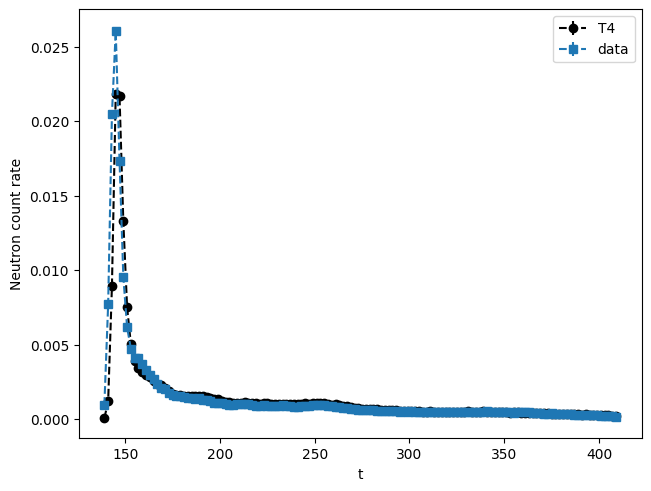

In [30]:
teq_res = test_equality.evaluate()
eqrepr = frepr(teq_res, verbosity=Verbosity.FULL_DETAILS)  # il s'agit d'une liste de templates
eqrst = rstformat.template(eqrepr[1])
print(eqrst)
mpl = MplPlot(eqrepr[0]).draw()

Avec un test de Holm-Bonferroni puisqu'il s'agit d'un spectre :

In [31]:
from valjean.gavroche.stat_tests.student import TestStudent
from valjean.gavroche.stat_tests.bonferroni import TestHolmBonferroni

In [32]:
sphere_b.globals
studt = TestStudent(t4ds, exp_data, name='Student test', ndf=sphere_b.globals['edition_batch_number'])
hb_res = TestHolmBonferroni(test=studt, name='Holm-Bonferroni test', description='').evaluate()

.. role:: hl

.. table::
    :widths: auto

    ==========  ===  ===========  ============  ===========  ==========  ================
       test     ndf       α       min(p-value)    min(α)     N rejected  Holm-Bonferroni?
    ==========  ===  ===========  ============  ===========  ==========  ================
    T4 vs data  136        0.005             0  3.67647e-05          40       :hl:`False`
    ==========  ===  ===========  ============  ===========  ==========  ================
    



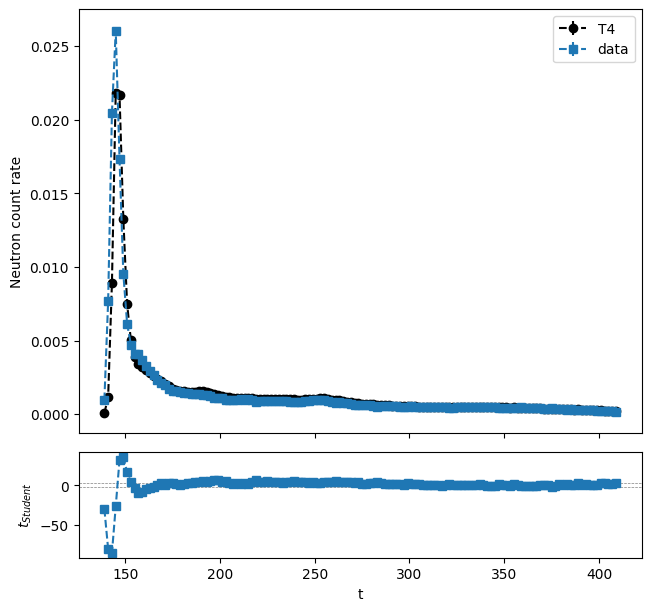

In [33]:
hbrepr = frepr(hb_res, verbosity=Verbosity.INTERMEDIATE)  # il s'agit d'une liste de templates
hbrst = rstformat.template(hbrepr[1])
print(hbrst)
mpl = MplPlot(hbrepr[0]).draw()

D'autres niveaux de verbosité sont disponibles. Il est également possible de changer un peu la représentation graphique des tests en utilisant une échelle logarithmique pour les données et la simulation par exemple.

In [34]:
from valjean.javert import plot_repr as pltr
def log_post(templates, tres):
    pltr.post_treatment(templates, tres)
    for templ in templates:
        templ.subplots[0].attributes.logy = True
    return templates

2
.. role:: hl

.. table::
    :widths: auto

    ==========  ===  ===========  ============  ===========  ==========  ================
       test     ndf       α       min(p-value)    min(α)     N rejected  Holm-Bonferroni?
    ==========  ===  ===========  ============  ===========  ==========  ================
    T4 vs data  136        0.005             0  3.67647e-05          40       :hl:`False`
    ==========  ===  ===========  ============  ===========  ==========  ================
    

.. role:: hl

.. table::
    :widths: auto

    ===  ===========  ===========  ===========  ===========  ===========  ===========
     t      v(T4)        σ(T4)       v(data)      σ(data)         t        Student?  
    ===  ===========  ===========  ===========  ===========  ===========  ===========
    139  5.55457e-05  3.10611e-06    0.0009519  2.99445e-05     -29.7741  :hl:`False`
    141   0.00118528  1.42187e-05       0.0077   7.9415e-05     -80.7498  :hl:`False`
    143   0.00893213  4.

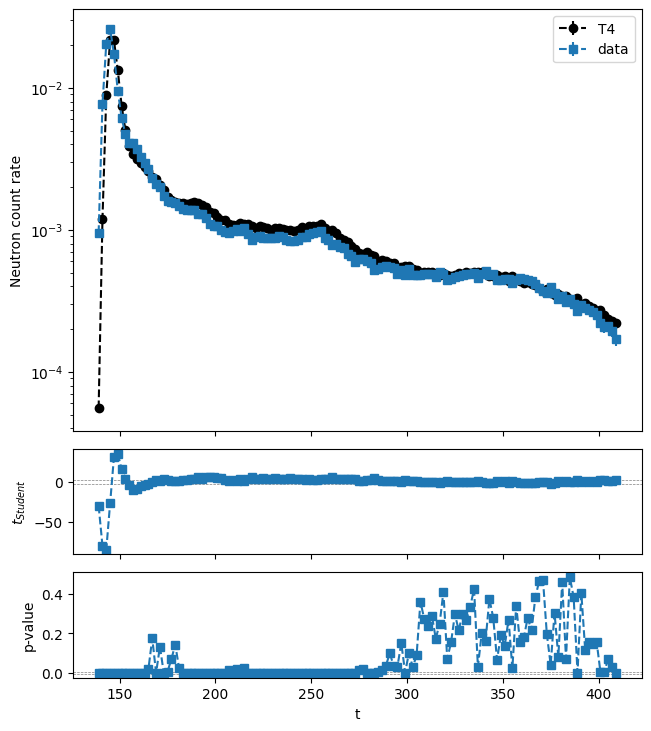

In [35]:
hbrepr = FullRepresenter(post=log_post)(hb_res, verbosity=Verbosity.FULL_DETAILS)  # il s'agit d'une liste de templates
print(len(hbrepr[1:]))
hbrst = '\n'.join([str(rstformat.template(hbrepr[1])), str(rstformat.template(hbrepr[2]))])
print(hbrst)
mpl = MplPlot(hbrepr[0]).draw()

L'impression des résultats des `TestStudent` dans le cas `FULL_DETAILS` donne le tableau de Student en `INTERMEDIATE`, soit les bins où le test à échouer.

**Remarque** : le test de Holm-Bonferroni n'est pas très adapté ici, comme nous comparons les données à la simulation, nous n'avons pas de nombre de degrés de liberté similaire pour les deux échantillons.

## Graphiques de comparaison entre les données expérimentales et Tripoli-4

L'analyse des données peut également être faite en dehors de **valjean** en fonction de ses nécessités.

Comme pour la lecture des résultats expérimentaux, une petite classe a été dérivée pour facilier et personnaliser les graphiques de comparaison.

La bibliothèque utilisée est `matplotlib`.

Dans notre cas, on souhaite aisément :

- ajouter une nouvelle courbe, avec ses erreurs
- visualiser le rapport entre les différentes courbes
- pouvoir personnaliser facilement la couleur et l'aspect des courbes (aisé grâce à `matplotlib`, les arguments sont juste transmis ici)

Cette petite classe, [CompPlot](comp_plots.py), est aussi disponible dans le notebook.

Le nom de « l'analyse » correspond à la clef pour les données expérimentales. Cela permet de générer par exemple le titre.

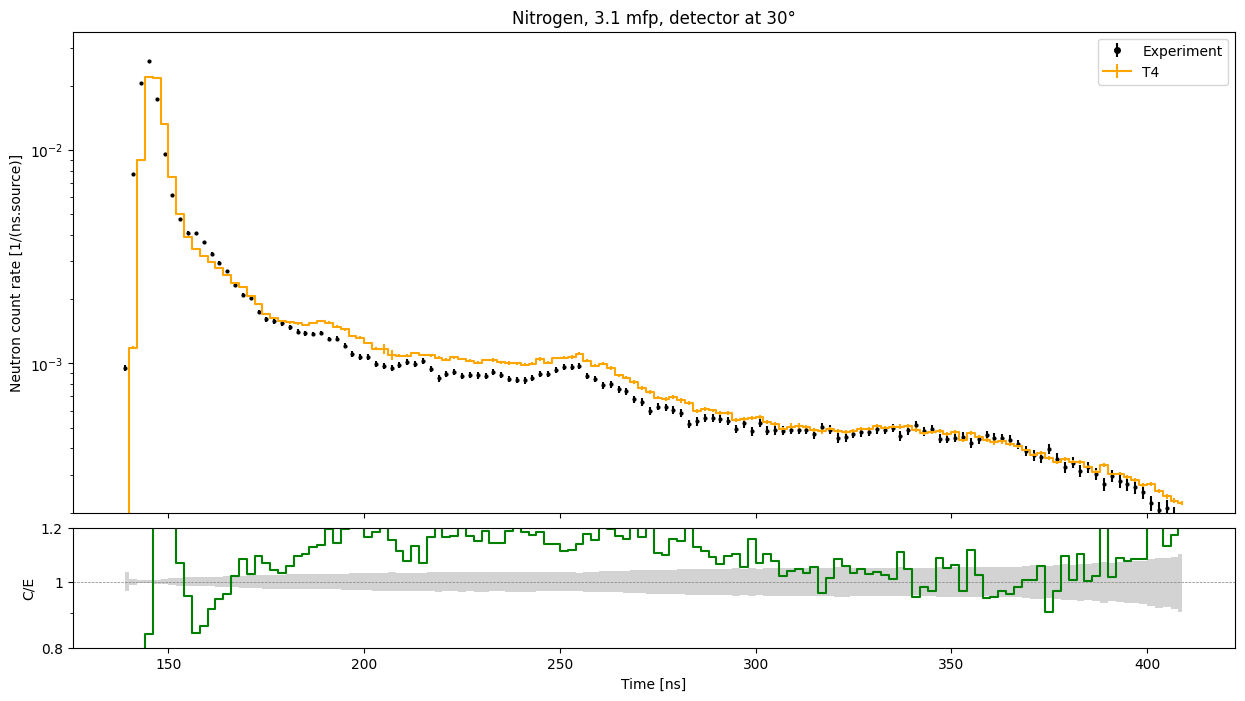

In [36]:
import matplotlib.pyplot as plt
from comp_plots import CompPlot

cplot = CompPlot(exp_key)
cplot.add_errorbar_plot(exp_data.bins['t'], exp_data.value, exp_data.error,
                        fmt='o', c='black', ms=2, ecolor='black', label='Experiment')
cplot.add_errorbar_plot(t4ds.bins['t'], t4ds.value, t4ds.error,
                        label='T4', drawstyle='steps-mid', fmt='-', c='orange')

cplot.add_errorbar_ratio(ratio.bins['t'], ratio.value, 0,
                         drawstyle='steps-mid', fmt='-', c='green')
cplot.splt[1].fill_between(
    ratio.bins['t'],
    np.ones(ratio.bins['t'].size) - exp_data.error/exp_data.value,
    np.ones(ratio.bins['t'].size) + exp_data.error/exp_data.value,
    facecolor='lightgrey', step='mid')
cplot.customize_plot()
plt.show()